In [1]:
import os

os.chdir('..')

In [1]:
import pickle
import itertools
import glob

import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import spearmanr

import configs
from utils import laion_utils as laionu
from utils import wordnet_utils as wnu
from core.ilsvrc_predictors import all_model_names_1k, all_model_names_pt21k_ft1k, all_model_names_21k
from core.queries import QueryType

[nltk_data] Downloading package wordnet to /Users/alishri/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Settings

## Path

In [2]:
# LAION with predictions
laion_path = 'laion400m'
laion_until_part = 31

laion_file_name = configs.LAIONConfig.SUBSET_SM_FILTERED_PREFIX \
                + configs.LAIONConfig.PREDICTED_PREFIX \
                + laionu.get_laion_subset_file_name(0, laion_until_part)

# ILSVRC predictions
ilsvrc_path = 'ilsvrc2012'

ilsvrc_val_file_name = 'ILSVRC2012_val_predicted.parquet'

# Labels (maps)
laion_labels_path = os.path.join('laion400m', 'processed', 'ilsvrc_labels')
wnid2laionindices_file_name = 'wnid2laionindices(substring_matched).pkl'

imagename2wnid_path = os.path.join('ilsvrc2012', 'processed', 'labels', 'imagename2wnid.pkl')

## Misc

In [3]:
top_k_col = lambda k, mdl: f'top_{k}_is_correct_{mdl}'

chosen_q_type = QueryType.NAME_DEF

# Image-query similarity
image_query_sim_col = f'image_to_{chosen_q_type}_wnid_similarity'

# Text-query similarity
text_query_sim_col = f'text_to_{chosen_q_type}_wnid_similarity'

## Models

In [4]:
model_names = all_model_names_1k + all_model_names_pt21k_ft1k + all_model_names_21k

print('\n'.join(model_names))

resnet-18
resnet-34
resnet-50
resnet-101
resnet-152
convnext-tiny-224
convnext-small-224
convnext-base-224
convnext-large-224
convnext-base-384
convnext-large-384
vit-base-patch16-224
vit-base-patch16-384
vit-base-patch32-384
vit-large-patch16-224
vit-large-patch16-384
vit-large-patch32-384
convnext-base-224-22k-1k
convnext-large-224-22k-1k
convnext-base-384-22k-1k
convnext-large-384-22k-1k
beit-base-patch16-224
beit-base-patch16-384
beit-large-patch16-224
beit-large-patch16-384
convnext-base-224-22k
convnext-large-224-22k
beit-base-patch16-224-pt22k-ft22k
beit-large-patch16-224-pt22k-ft22k


In [5]:
modelname2color = {}

for model_name in all_model_names_1k:
    modelname2color[model_name] = 'r'

for model_name in all_model_names_pt21k_ft1k:
    modelname2color[model_name] = 'y'
    
for model_name in all_model_names_21k:
    modelname2color[model_name] = 'g'

## Load LAION subset

In [6]:
df = pd.read_parquet(
    os.path.join(laion_path, laion_file_name)
)

df.head(3)

,SAMPLE_ID,URL,TEXT,HEIGHT,WIDTH,LICENSE,NSFW,similarity,a_photo_of_name_def_wnid,text_to_a_photo_of_name_def_wnid_similarity,...,top_5_is_correct_beit-large-patch16-224-pt22k-ft22k,top_1_is_correct_beit-base-patch16-224,top_5_is_correct_beit-base-patch16-224,top_1_is_correct_beit-base-patch16-384,top_5_is_correct_beit-base-patch16-384,top_1_is_correct_beit-large-patch16-224,top_5_is_correct_beit-large-patch16-224,top_1_is_correct_beit-large-patch16-384,top_5_is_correct_beit-large-patch16-384,image_to_text_similarity
1200056513,4.745710e+11,https://t1.ftcdn.net/jpg/00/75/08/12/240_F_750...,Colorful patchwork quilt pattern,373.0,240.0,?,UNLIKELY,0.328658,a photo of quilt which is bedding made of two ...,0.805882,...,True,True,True,True,True,True,True,True,True,0.325056
1200090089,1.129810e+11,https://farm6.staticflickr.com/5132/5411062185...,basket quilt top,320.0,285.0,?,UNLIKELY,0.310124,a photo of quilt which is bedding made of two ...,0.823052,...,True,True,True,True,True,True,True,True,True,0.314476
1200091068,4.145784e+12,https://theplaidporticodotcom4.files.wordpress...,QuiltCon charity quilt,584.0,820.0,?,UNLIKELY,0.307640,a photo of quilt which is bedding made of two ...,0.846488,...,None,None,None,None,None,None,None,None,None,NaN


## Load ILSVRC val set

In [8]:
ilsvrc_val_df = pd.read_parquet(os.path.join(ilsvrc_path, ilsvrc_val_file_name))

print(ilsvrc_val_df.shape)

ilsvrc_val_df.tail(3)

(50000, 74)


,image_to_name_def_wnid_similarity,name_def_wnid,top_1_is_correct_ResNet-50-1k,top_5_is_correct_ResNet-50-1k,top_1_is_correct_ConvNeXT-1k,top_5_is_correct_ConvNeXT-1k,top_1_is_correct_ConvNeXT-21k-1k,top_5_is_correct_ConvNeXT-21k-1k,top_1_is_correct_ViT-21k-1k,top_5_is_correct_ViT-21k-1k,...,top_1_is_correct_beit-large-patch16-224-pt22k-ft22k,top_5_is_correct_beit-large-patch16-224-pt22k-ft22k,top_1_is_correct_beit-base-patch16-224,top_5_is_correct_beit-base-patch16-224,top_1_is_correct_beit-base-patch16-384,top_5_is_correct_beit-base-patch16-384,top_1_is_correct_beit-large-patch16-224,top_5_is_correct_beit-large-patch16-224,top_1_is_correct_beit-large-patch16-384,top_5_is_correct_beit-large-patch16-384
ILSVRC2012_val_00049998.JPEG,0.305767,border collie which is developed in the area b...,False,True,False,True,True,True,False,True,...,False,True,True,True,True,True,True,True,False,True
ILSVRC2012_val_00049999.JPEG,0.251934,groom which is a man participant in his own ma...,True,True,True,True,True,True,True,True,...,False,False,True,True,True,True,True,True,True,True
ILSVRC2012_val_00050000.JPEG,0.303315,llama which is wild or domesticated South Amer...,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


## Load maps

In [9]:
with open(os.path.join(laion_labels_path, wnid2laionindices_file_name), 'rb') as f:
    wnid2laionindices = pickle.load(f)

In [10]:
with open(imagename2wnid_path, 'rb') as f:
    imagename2wnid = pickle.load(f)
    
# Find the inverse map
wnid2imagenames = {}
for image_name, wnid in imagename2wnid.items():
    if image_name not in ilsvrc_val_df.index:
        continue
    
    if wnid not in wnid2imagenames:
        wnid2imagenames[wnid] = []
    wnid2imagenames[wnid].append(image_name)

# Calc. accuracy

## Find ILSVRC val. accuracy

In [11]:
topk2model2wnid2ilsvrcrecall = {1: {}, 5: {}}

for k in [1, 5]:
    for model_name in model_names:
        topk2model2wnid2ilsvrcrecall[k][model_name] = {}
        for wnid, image_names in wnid2imagenames.items():
            vals = np.array(ilsvrc_val_df.loc[image_names, top_k_col(k, model_name)].tolist())
            mask = vals != None
            
            topk2model2wnid2ilsvrcrecall[k][model_name][wnid] = np.mean(vals[mask])

## Helper functions

In [14]:
def calc_recall_per_wnid(k, txt_query_sim_th, img_query_sim_th, n_q_res):
    mdl2wnid2recall = {}
    mdl2wnid2recallse = {}  # standard err

    for model_name in model_names:
        mdl2wnid2recall[model_name] = {}
        mdl2wnid2recallse[model_name] = {}

        for wnid, indices in wnid2laionindices.items():
            indices = np.array(indices)
            txt_query_sims = np.array(df.loc[indices, text_query_sim_col].tolist())
            img_query_sims = np.array(df.loc[indices, image_query_sim_col].tolist())
            
            # Filter based on text-to-query similarity
            filt_tq = txt_query_sims > txt_query_sim_th
            
            # Filter based on image-to-query similarity
            filt_iq = img_query_sims > img_query_sim_th
            
            # Filter
            filt = np.logical_and(filt_tq, filt_iq)
            indices = indices[filt]
            txt_query_sims = txt_query_sims[filt]

            # Keep top n_q_res
            top_results = np.argsort(txt_query_sims)[-n_q_res:]
            indices = indices[top_results]

            # Calc. recall
            col_list = df.loc[indices, top_k_col(k, model_name)].to_numpy()
            
            mask = col_list != None
            
            n = np.sum(mask)

            if n == 0:
                mdl2wnid2recall[model_name][wnid] = np.nan
                mdl2wnid2recallse[model_name][wnid] = np.nan
                continue

            count = np.sum(col_list[mask])

            recall = count/n

            mdl2wnid2recall[model_name][wnid] = recall
            ci_l, ci_u = proportion_confint(count, n, method='wilson', alpha=alpha)
            mdl2wnid2recallse[model_name][wnid] = (ci_u - ci_l)/2/z
                
    return mdl2wnid2recall, mdl2wnid2recallse


def combine_recalls(means, ses, w):
    nan_filt = ~np.isnan(means)
    means = means[nan_filt]
    ses = ses[nan_filt]
    w = w[nan_filt]
    
    mean = np.sum(means * w)/np.sum(w)
    se = np.sqrt(np.sum((ses * w)**2))/np.sum(w)
    
    return mean, se


def calc_equi_acc(mdl2wnid2recall, mdl2wnid2recallse):
    mdl2acc = {}
    mdl2nwnid = {}
    for model_name in model_names:
        recalls = []
        recallses = []
        for wnid, recall in mdl2wnid2recall[model_name].items():
            recalls.append(recall)
            recallses.append(mdl2wnid2recallse[model_name][wnid])

        recalls = np.array(recalls)
        recallses = np.array(recallses)

        acc, acc_se = combine_recalls(recalls, recallses, np.ones(recalls.shape))

        mdl2acc[model_name] = {
            'acc': acc, 
            'acc_se': acc_se,
        }
        
        mdl2nwnid[model_name] = np.sum(~np.isnan(recalls))
            
    return mdl2acc, mdl2nwnid


def calc_ilsvrc_val_acc(mdl2wnid2recall):
    mdl2ilsvrcacc ={} 

    for model_name in mdl2wnid2recall:
        wnids = [wnid for wnid, recall in mdl2wnid2recall[model_name].items() if not np.isnan(recall)]
        recalls = []
        for wnid in wnids:
            if wnid not in topk2model2wnid2ilsvrcrecall[top_k][model_name]:
                continue

            recalls.append(topk2model2wnid2ilsvrcrecall[top_k][model_name][wnid])

        mdl2ilsvrcacc[model_name] = np.mean(recalls)
        
    return mdl2ilsvrcacc

## Params

In [51]:
text_query_sim_th = 0.82  # 0.82
image_query_sim_th = 0
n_q_result = 0  # 0 means all

top_k = 5

alpha = 0.05
z = 1.96

## Calc. recall per WNID

In [52]:
model2wnid2recall, model2wnid2recallse = \
    calc_recall_per_wnid(
        top_k, 
        text_query_sim_th, 
        image_query_sim_th,
        n_q_result
    )

## Calc. accuracy with equi-weighted classes

In [53]:
model2acc, model2nwnid = calc_equi_acc(model2wnid2recall, model2wnid2recallse)

model2ilsvrcacc = calc_ilsvrc_val_acc(model2wnid2recall)

## Plot accuracy vs. papers

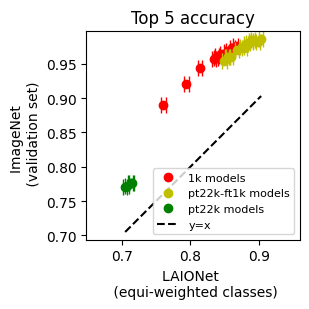

In [54]:
plt.figure(figsize=(3.2, 3.2))

min_acc, max_acc = np.inf, -np.inf
modelname2handle = {}
for model_name in model_names:
    cl = modelname2color[model_name]

    acc = model2acc[model_name]['acc']
    acc_se = model2acc[model_name]['acc_se']

    h = plt.plot(acc, model2ilsvrcacc[model_name], 'o', color=cl)
    plt.errorbar(
        acc, 
        model2ilsvrcacc[model_name],
        xerr=acc_se*z, 
        capsize=6,
        color=cl
    )

    min_acc = np.minimum(min_acc, acc)
    max_acc = np.maximum(max_acc, acc)

    modelname2handle[model_name] = h[0]


h = plt.plot([min_acc, max_acc], [min_acc, max_acc], 'k--')

plt.legend(
    handles=[
        modelname2handle[all_model_names_1k[0]],
        modelname2handle[all_model_names_pt21k_ft1k[0]],
        modelname2handle[all_model_names_21k[0]],
        h[0]
    ],
    labels=['1k models', 'pt22k-ft1k models', 'pt22k models', 'y=x'],
    loc='lower right',
    fontsize=8
)

plt.title(f'Top {top_k} accuracy')
plt.xlabel('LAIONet \n (equi-weighted classes)')
plt.ylabel('ImageNet \n (validation set)')

plt.axis('equal')

plt.tight_layout()

plt.savefig(os.path.join('figs', 'top%d_equi-acc_vs_ilsvrc-val-acc(tqsim%.2f).pdf' % (top_k, text_query_sim_th)), bbox_inches='tight')
    

# Calc. accuracy per text-to-query similarity

In [ ]:
text_query_sim_ths = np.linspace(0.82, 0.9, 15)
chosen_image_query_sim_th = 0
chosen_n_q_result = 0

tqsim2model2acc = {}
tqsim2model2ilsvrcacc = {}
tqsim2model2nwnid = {}

for tqsim in tqdm(text_query_sim_ths):    
    model2wnid2recall_i, model2wnid2recallse_i = \
        calc_recall_per_wnid(
            top_k, 
            tqsim,
            chosen_image_query_sim_th,
            chosen_n_q_result
        )
    
    tqsim2model2acc[tqsim], tqsim2model2nwnid[tqsim] = calc_equi_acc(model2wnid2recall_i, model2wnid2recallse_i)
    tqsim2model2ilsvrcacc[tqsim] = calc_ilsvrc_val_acc(model2wnid2recall_i)


## Plot acc. vs. text-query sim

In [ ]:
plt.figure(figsize=(5, 4))

chosen_model_names = ['convnext-base-224', 'convnext-base-224-22k-1k', 'convnext-base-224-22k']

handles = []
for model_name in chosen_model_names:
    cl = modelname2color[model_name]
    
    accs = np.array([tqsim2model2acc[tqsim][model_name]['acc'] for tqsim in text_query_sim_ths])
    acc_ses = np.array([tqsim2model2acc[tqsim][model_name]['acc_se'] for tqsim in text_query_sim_ths])
    
    h = plt.plot(text_query_sim_ths, accs, color=cl)
    plt.fill_between(text_query_sim_ths, accs + acc_ses*z, accs - acc_ses*z, color=cl, alpha=0.1, label='')
    
    handles.extend(h)
    
    # Plot the ILSVRC performance
    ilsvrc_accs = np.array([tqsim2model2ilsvrcacc[tqsim][model_name] for tqsim in text_query_sim_ths])
    
    plt.plot(text_query_sim_ths, ilsvrc_accs, '--', color=cl)

    
plt.legend(handles=handles, labels=chosen_model_names)

plt.xlabel('min. text-query CLIP similarity')
plt.ylabel(f'top{top_k} accuracy (LAION, equi-weighted classes)')

plt.tight_layout()

plt.savefig(os.path.join('figs', 'top%d_equi-acc_vs_tqsim.pdf' % top_k))

## Plot number of classes vs. text-query sim

In [ ]:
plt.figure(figsize=(5, 4))

for model_name in chosen_model_names:
    cl = modelname2color[model_name]
    
    nwnids = np.array([tqsim2model2nwnid[tqsim][model_name] for tqsim in text_query_sim_ths])

    plt.plot(text_query_sim_ths, nwnids, color=cl)
        
plt.legend(chosen_model_names)

plt.xlabel('min. image-image CLIP similarity')
plt.ylabel('num. classes with at least one example')

plt.tight_layout()

plt.savefig(os.path.join('figs', 'nwnid_vs_tqsim.pdf'))

# Relative frequency of the classes

In [19]:
n = np.sum([len(laion_indices) for _, laion_indices in wnid2laionindices.items()])

wnid2freq = {wnid: len(laion_indices) for wnid, laion_indices in wnid2laionindices.items() if len(laion_indices) > 0}

# Sort it by freq
wnid2freq = dict(sorted(wnid2freq.items(), key=lambda item: -item[1]))

# Find prob.
wnid2prob = {wnid: freq/n for wnid, freq in wnid2freq.items()}

## Calc. stat.

In [20]:
wnids = list(wnid2freq.keys())

synsets = []
freqs = []
for wnid in wnids:
    synsets.append(wnu.get_synset(wnid).name().split('.n')[0])
    freqs.append(wnid2freq[wnid])

imagenet_tot = np.sum(freqs)

In [21]:
print('Out of roughly 400M LAION samples, %d (%.2f%%) of them have at least one ImageNet class.'
      % (imagenet_tot, imagenet_tot/4e8*100))

Out of roughly 400M LAION samples, 879221 (0.22%) of them have at least one ImageNet class.


## Plot freq.

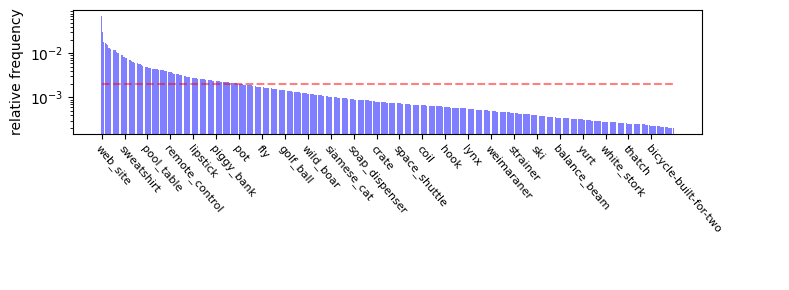

In [43]:
plt.figure(figsize=(8, 3))

freqs = freqs[:500]
synsets = synsets[:500]

n = len(freqs)

plt.bar(synsets, freqs/imagenet_tot, color='b', alpha=0.5)
plt.plot([0, n - 1], [1/n]*2, 'r--', alpha=0.5)

plt.ylabel('relative frequency')
# plt.xlabel('synsets (sampled)', fontsize=18)

plt.xticks(rotation=-50, ha='left', rotation_mode='anchor', fontsize=8)

ax = plt.gca()
xticks = ax.xaxis.get_major_ticks()
for i_x, xtick in enumerate(xticks):
    if i_x % 20 != 0:
        xtick.set_visible(False)
        
plt.yscale('log')

plt.tight_layout()

plt.savefig(os.path.join('figs', 'relative_freq(all).pdf'), bbox_inches='tight')

# Accuracy vs. frequency

In [25]:
print(top_k, text_query_sim_th, image_query_sim_th, n_q_result)

1 0.82 0 0


In [26]:
model2wnid2recall, model2wnid2recallse = \
    calc_recall_per_wnid(
        top_k, 
        text_query_sim_th, 
        image_query_sim_th,
        n_q_result
    )

In [27]:
chosen_model_names = [
    'resnet-50',
    'convnext-base-224',
    'convnext-base-224-22k-1k',
    'vit-base-patch16-224', 
]

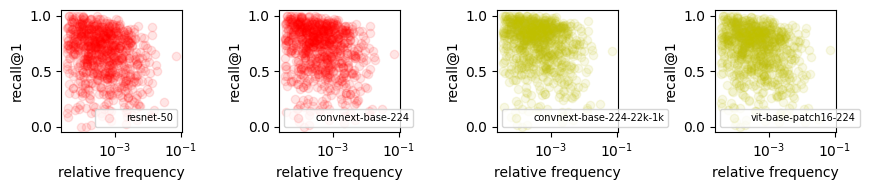

In [28]:
n_m = len(chosen_model_names)

plt.figure(figsize=(n_m*2.2, 2))

for i_m, model_name in enumerate(chosen_model_names):
    recalls = []
    probs = []
    for wnid, prob in wnid2prob.items():
        if wnid2freq[wnid] < 30:
            continue
        recalls.append(model2wnid2recall[model_name][wnid])
        probs.append(prob)
        
    plt.subplot(1, n_m, i_m + 1)
    cl = modelname2color[model_name]
    
    plt.plot(probs, recalls, 'o', alpha=0.1, color=cl)
    
    plt.legend([model_name], fontsize=7)
    plt.xlabel('relative frequency')
    plt.ylabel('recall@%d' % top_k)

    plt.xscale('log')
    
plt.tight_layout()

plt.savefig(os.path.join('figs', 'top%d_acc_vs_rel_freq.pdf' % top_k))

# Accuracy vs. intra-class similarity

## Load sims and find the average sim.

In [29]:
cross_image_sim_prefix = 'img_img_sims'
cross_image_sim_path = os.path.join('laion400m', 'processed', 'clip_image_similarities')

laion_prefix = configs.LAIONConfig.SUBSET_SM_FILTERED_PREFIX
ilsvrc_prefix = 'imagenet_captions_'

sim_key = 'similarities'

def vec(x):
    msk = np.tril(np.eye(len(x)) < 0.5)
    return x[msk]

In [30]:
wnid2avglsim = {}
wnid2avgisim = {}
for wnid in tqdm(wnid2laionindices):
    l_sim_path = os.path.join(cross_image_sim_path, laion_prefix + cross_image_sim_prefix + f'({wnid}).pkl')
    i_sim_path = os.path.join(cross_image_sim_path, ilsvrc_prefix + cross_image_sim_prefix + f'({wnid}).pkl')
    
    if (not os.path.exists(l_sim_path)) or (not os.path.exists(i_sim_path)):
        continue

    with open(l_sim_path, 'rb') as f:
        l_sim_dict = pickle.load(f)
    with open(i_sim_path, 'rb') as f:
        i_sim_dict = pickle.load(f)
        
    if (not isinstance(l_sim_dict, dict)):
        continue
        
    wnid2avglsim[wnid] = np.mean(vec(l_sim_dict[sim_key]))
    wnid2avgisim[wnid] = np.mean(vec(i_sim_dict[sim_key]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 978/978 [00:03<00:00, 278.17it/s]


## Plot

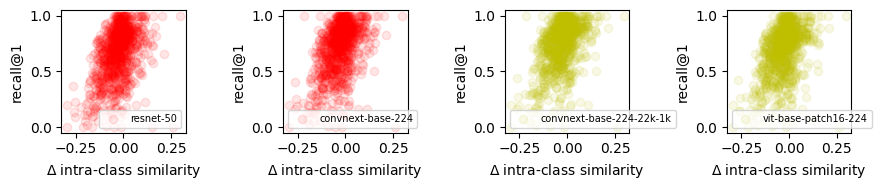

In [31]:
n_m = len(chosen_model_names)

plt.figure(figsize=(n_m*2.2, 2))

for i_m, model_name in enumerate(chosen_model_names):
    recalls = []
    sims = []
    for wnid, sim in wnid2avglsim.items():
        if wnid not in model2wnid2recall[model_name]:
            continue
            
        recalls.append(model2wnid2recall[model_name][wnid])
        sims.append(sim - wnid2avgisim[wnid])
        
    plt.subplot(1, n_m, i_m + 1)
    cl = modelname2color[model_name]
    
    plt.plot(sims, recalls, 'o', alpha=0.1, color=cl)
    
    plt.legend([model_name], fontsize=7)
    plt.xlabel(r'$\Delta$ intra-class similarity')
    plt.ylabel('recall@%d' % top_k)
    
plt.tight_layout()

plt.savefig(os.path.join('figs', 'top%d_acc_vs_intra-class_sim.pdf' % top_k))

# Intra-class similarity vs. frequency

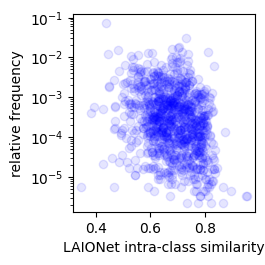

In [110]:
n_m = len(chosen_model_names)

plt.figure(figsize=(2.75, 2.75))

probs = []
sims = []
for wnid, sim in wnid2avglsim.items():
    probs.append(wnid2prob[wnid])
    sims.append(sim - 0*wnid2avgisim[wnid])

plt.plot(sims, probs, 'o', alpha=0.1, color='b')

plt.xlabel('LAIONet intra-class similarity')
plt.ylabel('relative frequency')

plt.yscale('log')
    
plt.tight_layout()

plt.savefig(os.path.join('figs', 'intra-class_sim_vs_rel_freq.pdf'))

In [112]:
spearmanr(np.log(probs), sims)

SpearmanrResult(correlation=-0.2645336715916952, pvalue=7.619530816017947e-16)

# LAION-weighted accuracy

In [44]:
# Sanity check
print(np.sum([prob for _, prob in wnid2prob.items()]))

1.0000000000000002


## Helper functions

In [45]:
def calc_laion_acc(mdl2wnid2recall, mdl2wnid2recallse, wnid2p):
    mdl2acc = {}
    mdl2nwnid = {}
    for model_name in model_names:
        recalls = []
        recallses = []
        weights = []
        for wnid, recall in mdl2wnid2recall[model_name].items():
            recalls.append(recall)
            recallses.append(mdl2wnid2recallse[model_name][wnid])
            weights.append(wnid2p.get(wnid, 0))

        recalls = np.array(recalls)
        recallses = np.array(recallses)
        weights = np.array(weights)

        acc, acc_se = combine_recalls(recalls, recallses, weights)

        mdl2acc[model_name] = {
            'acc': acc, 
            'acc_se': acc_se,
        }
        
        mdl2nwnid[model_name] = np.sum(~np.isnan(recalls))
            
    return mdl2acc, mdl2nwnid

## Calc. acc

In [46]:
print(top_k, text_query_sim_th, image_query_sim_th, n_q_result)

1 0.82 0 0


In [47]:
model2wnid2recall, model2wnid2recallse = \
    calc_recall_per_wnid(
        top_k, 
        text_query_sim_th, 
        image_query_sim_th,
        n_q_result
    )

In [55]:
model2acc, model2nwnid = calc_equi_acc(model2wnid2recall, model2wnid2recallse)

model2laionacc, _ = calc_laion_acc(model2wnid2recall, model2wnid2recallse, wnid2prob)

## Plot LAION-weighted accuracy vs. equi-weighted accuracy

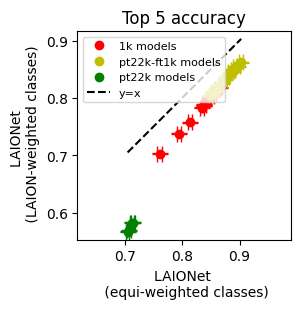

In [56]:
plt.figure(figsize=(3.2, 3.2))

min_acc, max_acc = np.inf, -np.inf
modelname2handle = {}
for model_name in model_names:
    cl = modelname2color[model_name]

    acc = model2acc[model_name]['acc']
    acc_se = model2acc[model_name]['acc_se']
    
    acc_laion = model2laionacc[model_name]['acc']
    acc_laion_se = model2laionacc[model_name]['acc_se']

    h = plt.plot(acc, acc_laion, 'o', color=cl)
    plt.errorbar(
        acc, 
        acc_laion,
        xerr=acc_se*z, 
        yerr=acc_laion_se*z,
        capsize=6,
        color=cl
    )

    min_acc = np.minimum(min_acc, acc)
    max_acc = np.maximum(max_acc, acc)

    modelname2handle[model_name] = h[0]


h = plt.plot([min_acc, max_acc], [min_acc, max_acc], 'k--')

plt.legend(
    handles=[
        modelname2handle[all_model_names_1k[0]],
        modelname2handle[all_model_names_pt21k_ft1k[0]],
        modelname2handle[all_model_names_21k[0]],
        h[0]
    ],
    labels=['1k models', 'pt22k-ft1k models', 'pt22k models', 'y=x'],
    loc='upper left',
    fontsize=8
)

plt.title(f'Top {top_k} accuracy')
plt.xlabel('LAIONet \n (equi-weighted classes)')
plt.ylabel('LAIONet \n (LAION-weighted classes)')

plt.axis('equal')

plt.tight_layout()

plt.savefig(os.path.join('figs', 'top%d_natural-acc_vs_equi-acc(tqsim%.2f).pdf' % (top_k, text_query_sim_th)), bbox_inches='tight')
    